Baseline Seqlab KMER uses Untari et. al. paradigm: Nucleotides are converted into kmer form and thus the labels are also converted.

# Libraries

Import Libraries

In [2]:
# Import Lib
import numpy as np
import pandas as pd
import pickle
import time
import keras
import keras.utils
import tensorflow as tf
from keras.layers import Embedding, Dense, Flatten, Dropout, SpatialDropout1D, TimeDistributed, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import Input, Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import os

Hyperparameter

In [3]:
path = '/drive/MyDrive/Sequence Processing Baseline/'
datapath = path + 'Dataset/'
modelpath = path + 'Model/'
gene = 'EGFR'
# Hyperparameter
window_size = 512
stride = 50
testSchem = 'Uniform'
sampling = 'RUS' # '_' or 'RUS' (Random Undersampling)
num_classes = 8
vocab_size = 64
# model_dir = os.path.join("drive", "MyDrive", "Sequence Processing Baseline", "model-kmer")
model_dir = os.path.join("run", "baseline", "model-kmer")
# data_dir = os.path.join("drive", "MyDrive", "Sequence Processing Baseline", "kmer")
data_dir = os.path.join("data", "baseline", "kmer")
for d in [model_dir, data_dir]:
    os.makedirs(d, exist_ok=True)

Dictionary

In [4]:
import numpy as np
characters = ["A", "C", "G", "T"]

kmer_dict = {}
count = 0
embedding_vectors = []
for a in characters:
  for b in characters:
    for c in characters:
      v = [0 for i in range(64)]
      kmer_dict[f"{a}{b}{c}"] = count
      v[count] = 1
      embedding_vectors.append(v)
      count += 1

embedding_vectors = np.array(embedding_vectors)
print(embedding_vectors.shape)
print(kmer_dict)
embedding_matrix = embedding_vectors

Label_Dictionary = {
    '[CLS]': -100, #_create_one_hot_encoding(0, 10),
    '[SEP]': -100,
    # '[PAD]': 2, #_create_one_hot_encoding(9, 10)
    'III': -100,   # Created III instead of iii for PAD special token. 
                # This is for enabling reading contigs if token is predicted as padding. 
                # #_create_one_hot_encoding(9, 10)
    'iii': 0,   #_create_one_hot_encoding(1, 10),
    'iiE': 1,   #_create_one_hot_encoding(2, 10),
    'iEi': 2,   #_create_one_hot_encoding(3, 10),
    'Eii': 3,   #_create_one_hot_encoding(4, 10),
    'iEE': 4,   #_create_one_hot_encoding(5, 10),
    'EEi': 5,   #_create_one_hot_encoding(6, 10),
    'EiE': 6,   #_create_one_hot_encoding(7, 10),
    'EEE': 7,  #_create_one_hot_encoding(8, 10),
}

label_dict = Label_Dictionary

Index_Dictionary = {
    #0: "[CLS]",
    #1: "[SEP]",
    #2: "III",       # Use `III` as padding symbol.
    0: "iii",
    1: "iiE",
    2: "iEi",
    3: "Eii",
    4: "iEE",
    5: "EEi",
    6: "EiE",
    7: "EEE",
    -100: "[CLS]/[SEP]/[III]"
}

(64, 64)
{'AAA': 0, 'AAC': 1, 'AAG': 2, 'AAT': 3, 'ACA': 4, 'ACC': 5, 'ACG': 6, 'ACT': 7, 'AGA': 8, 'AGC': 9, 'AGG': 10, 'AGT': 11, 'ATA': 12, 'ATC': 13, 'ATG': 14, 'ATT': 15, 'CAA': 16, 'CAC': 17, 'CAG': 18, 'CAT': 19, 'CCA': 20, 'CCC': 21, 'CCG': 22, 'CCT': 23, 'CGA': 24, 'CGC': 25, 'CGG': 26, 'CGT': 27, 'CTA': 28, 'CTC': 29, 'CTG': 30, 'CTT': 31, 'GAA': 32, 'GAC': 33, 'GAG': 34, 'GAT': 35, 'GCA': 36, 'GCC': 37, 'GCG': 38, 'GCT': 39, 'GGA': 40, 'GGC': 41, 'GGG': 42, 'GGT': 43, 'GTA': 44, 'GTC': 45, 'GTG': 46, 'GTT': 47, 'TAA': 48, 'TAC': 49, 'TAG': 50, 'TAT': 51, 'TCA': 52, 'TCC': 53, 'TCG': 54, 'TCT': 55, 'TGA': 56, 'TGC': 57, 'TGG': 58, 'TGT': 59, 'TTA': 60, 'TTC': 61, 'TTG': 62, 'TTT': 63}


# Data Samples

Preprocessing

In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

training_data_path = os.path.join(data_dir, "gene_index.01_train_validation_ss_all_pos_train.csv")
validation_data_path = os.path.join(data_dir, "gene_index.01_train_validation_ss_all_pos_validation.csv")
test_data_path = os.path.join(data_dir, "gene_index.01_test_ss_all_pos.csv")

def preprocessing(data_path):
  if os.path.exists(data_path):
    print(f"data exists at {data_path}")
  else:
    raise FileNotFoundError(f"data not found ata {data_path}")
  encoded_sequences = []
  encoded_labels = []
  df = pd.read_csv(data_path)
  for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Preprocessing"):
    sequence = r["sequence"]
    label = r["label"]

    encoded_sequence = [kmer_dict[a] for a in sequence.split(' ')]
    encoded_label = [label_dict[a] for a in label.split(' ')]
    encoded_sequences.append(
        encoded_sequence
    )
    encoded_labels.append(
        encoded_label
    )
  return encoded_sequences, encoded_labels

X_train, Y_train = preprocessing(training_data_path)
X_train = np.array(X_train)
Y_train = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_train])
X_val, Y_val = preprocessing(validation_data_path)
X_val = np.array(X_val)
Y_val = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_val])
X_test, Y_test = preprocessing(test_data_path)
X_test = np.array(X_test)
Y_test = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_test])

print(f"Training data {np.array(X_train).shape}, {np.array(Y_train).shape}")
print(f"Validation data {np.array(X_val).shape}, {np.array(Y_val).shape}")
print(f"Test data {np.array(X_test).shape}, {np.array(Y_test).shape}")


data exists at data\baseline\kmer\gene_index.01_train_validation_ss_all_pos_train.csv


Preprocessing: 100%|██████████| 71058/71058 [00:34<00:00, 2074.00it/s]


data exists at data\baseline\kmer\gene_index.01_train_validation_ss_all_pos_validation.csv


Preprocessing: 100%|██████████| 17765/17765 [00:06<00:00, 2723.14it/s]


data exists at data\baseline\kmer\gene_index.01_test_ss_all_pos.csv


Preprocessing: 100%|██████████| 6977/6977 [00:02<00:00, 2798.83it/s]


Training data (71058, 512), (71058, 512, 8)
Validation data (17765, 512), (17765, 512, 8)
Test data (6977, 512), (6977, 512, 8)


In [5]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# Model BiLSTM

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 64)           4096      
                                                                 
 bidirectional (Bidirectiona  (None, 512, 512)         657408    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 512)         1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512, 512)          0     

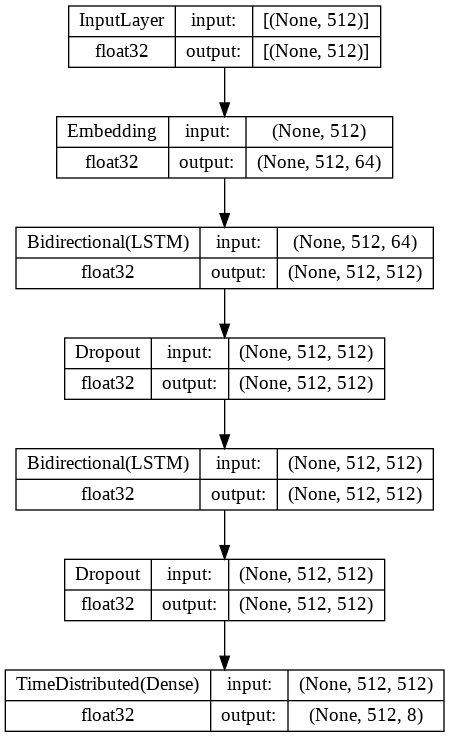

In [5]:
dnn = 'BiLSTM'
numlayer = 2
units = 256 #unit LSTM
dropout = 0.2
layer = str(numlayer)+'_'+str(units)
embedding_dim = embedding_matrix.shape[1]
window_size = 512
stride = 50

def model_bilstm():
  # Architecture:
  input = Input(shape=(window_size,)) # Input layer
  model = Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix],
                    input_length = window_size, 
                    trainable=False)(input)
  model = Bidirectional(LSTM(units, return_sequences=True))(model)
  if dropout>0:
    model = Dropout(dropout)(model)
  if numlayer==2:
    model = Bidirectional(LSTM(units, return_sequences=True))(model)
    if dropout>0:
      model = Dropout(dropout)(model)
  out = TimeDistributed(Dense(num_classes, activation="softmax"))(model)  # TimeDistributed wrapper layer, return sequences. Fully connected layer. 
  model = Model(input, out)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', "precision", "recall"])
  model.summary()
  return model

m = model_bilstm()
tf.keras.utils.plot_model(
    m, to_file="model_bilstm.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=False, 
    rankdir="TB", 
    expand_nested=True, 
    dpi=96
)

# Training Model BiLSTM

In [6]:
model = model_bilstm()
train_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=48)
model.save(
    os.path.join(model_dir, "model_bilstm.h5")
)
training_loss_history = train_history.history["loss"]
validation_loss_history = train_history.history["val_loss"]

train_history.history.keys()
train_loss = train_history.history["loss"]
train_accuracy = train_history.history["accuracy"]
val_loss = train_history.history["val_loss"]
val_accuracy = train_history.history["val_accuracy"]

import pandas as pd

training_validation_result_df = pd.DataFrame(data={
    "training_loss": train_loss,
    "validation_loss": val_loss,
    "training_accuracy": train_accuracy,
    "validation_accuracy": val_accuracy
})
training_validation_result_df.to_csv(f"training_validation_log.arch[bilstm].windows-size[{window_size}].stride[1].csv", index=False)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 512, 64)           4096      
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 512)         657408    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 512, 512)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 512, 512)         1574912   
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 512, 512)          0   

{'verbose': 1, 'epochs': 20, 'steps': 1481}
20


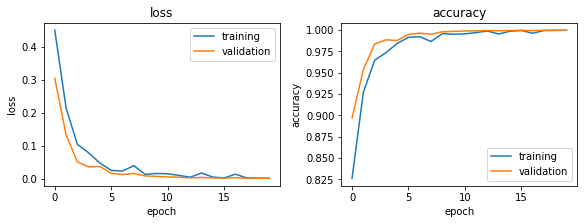

In [8]:
print(train_history.params)
print(len(train_history.history["loss"]))

import matplotlib.pyplot as plt
figs, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 3))
axes[0].plot(
    [e for e in range(20)],
    train_history.history["loss"],
    label="training"
)
axes[0].plot(
    [e for e in range(20)],
    train_history.history["val_loss"],
    label="validation"
)
axes[0].set(xlabel="epoch", ylabel="loss", title="loss")
axes[0].legend()
axes[1].plot(
    [e for e in range(20)],
    train_history.history["accuracy"],
    label="training"
)
axes[1].plot(
    [e for e in range(20)],
    train_history.history["val_accuracy"],
    label="validation"
)
axes[1].set(xlabel="epoch", ylabel="accuracy", title="accuracy")
axes[1].legend()
plt.show()


# Model BiGRU

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 512, 64)           4096      
                                                                 
 bidirectional_4 (Bidirectio  (None, 512, 512)         494592    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 512, 512)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 512, 512)         1182720   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512, 512)          0   

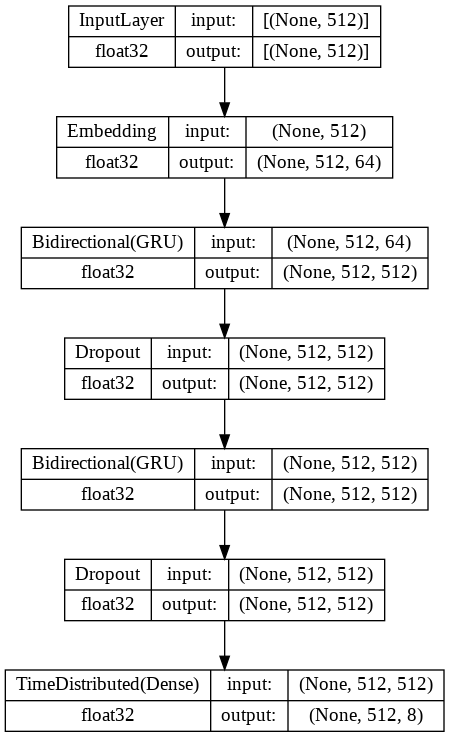

In [9]:
dnn = 'BiGRU'
numlayer = 2
units = 256 #unit LSTM
dropout = 0.2
layer = str(numlayer)+'_'+str(units)
num_classes = 8
vocab_size = 64
embedding_dim = embedding_matrix.shape[1]
window_size = 512
stride = 50

def model_bigru():
  # Architecture:
  input = Input(shape=(window_size,)) # Input layer
  model = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                          input_length = window_size, trainable=False)(input)
  model = Bidirectional(GRU(units, return_sequences=True))(model)
  if dropout>0:
    model = Dropout(dropout)(model)
  if numlayer==2:
    model = Bidirectional(GRU(units, return_sequences=True))(model)
    if dropout>0:
      model = Dropout(dropout)(model)
  out = TimeDistributed(Dense(num_classes, activation="softmax"))(model)  # TimeDistributed wrapper layer, return sequences. Fully connected layer. 
  model = Model(input, out)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

m = model_bigru()
tf.keras.utils.plot_model(
    m, to_file="model_bigru.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=False, 
    rankdir="TB", 
    expand_nested=True, 
    dpi=96
)

# Training Model BiGRU

In [10]:
model_bigru = model_bigru()
train_history_bigru = model_bigru.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=48)
model_bigru.save(
    os.path.join(model_dir, "model_bigru.h5")
)
training_loss_history_bigru = train_history_bigru.history["loss"]
validation_loss_history_bigru = train_history_bigru.history["val_loss"]

train_history_bigru.history.keys()
train_loss_bigru = train_history_bigru.history["loss"]
train_accuracy_bigru = train_history_bigru.history["accuracy"]
val_loss_bigru = train_history_bigru.history["val_loss"]
val_accuracy_bigru = train_history_bigru.history["val_accuracy"]

import pandas as pd

training_validation_result_df = pd.DataFrame(data={
    "training_loss": train_loss_bigru,
    "validation_loss": val_loss_bigru,
    "training_accuracy": train_accuracy_bigru,
    "validation_accuracy": val_accuracy_bigru
})
training_validation_result_df.to_csv(f"training_validation_log.arch[bigru].windows-size[{window_size}].stride[1].csv", index=False)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 512, 64)           4096      
                                                                 
 bidirectional_6 (Bidirectio  (None, 512, 512)         494592    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 512, 512)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 512, 512)         1182720   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 512, 512)          0   

{'verbose': 1, 'epochs': 20, 'steps': 1481}
20


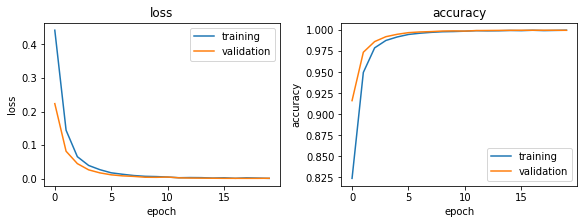

In [12]:
print(train_history_bigru.params)
print(len(train_history_bigru.history["loss"]))

import matplotlib.pyplot as plt
figs, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 3))
axes[0].plot(
    [e for e in range(20)],
    train_history_bigru.history["loss"],
    label="training"
)
axes[0].plot(
    [e for e in range(20)],
    train_history_bigru.history["val_loss"],
    label="validation"
)
axes[0].set(xlabel="epoch", ylabel="loss", title="loss")
axes[0].legend()
axes[1].plot(
    [e for e in range(20)],
    train_history_bigru.history["accuracy"],
    label="training"
)
axes[1].plot(
    [e for e in range(20)],
    train_history_bigru.history["val_accuracy"],
    label="validation"
)
axes[1].set(xlabel="epoch", ylabel="accuracy", title="accuracy")
axes[1].legend()
plt.show()

# Training & Validation Result

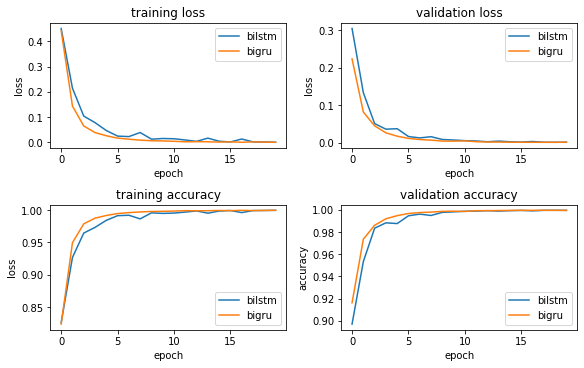

In [13]:
import matplotlib.pyplot as plt
figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# training loss
axes[0][0].plot(
    [e for e in range(20)],
    train_history.history["loss"],
    label="bilstm"
)
axes[0][0].plot(
    [e for e in range(20)],
    train_history_bigru.history["loss"],
    label="bigru"
)
axes[0][0].set(xlabel="epoch", ylabel="loss", title="training loss")
axes[0][0].legend()

# validation loss
axes[0][1].plot(
    [e for e in range(20)],
    train_history.history["val_loss"],
    label="bilstm"
)
axes[0][1].plot(
    [e for e in range(20)],
    train_history_bigru.history["val_loss"],
    label="bigru"
)
axes[0][1].set(xlabel="epoch", ylabel="loss", title="validation loss")
axes[0][1].legend()

# training accuracy
axes[1][0].plot(
    [e for e in range(20)],
    train_history.history["accuracy"],
    label="bilstm"
)
axes[1][0].plot(
    [e for e in range(20)],
    train_history_bigru.history["accuracy"],
    label="bigru"
)
axes[1][0].set(xlabel="epoch", ylabel="loss", title="training accuracy")
axes[1][0].legend()

# validation accuracy
axes[1][1].plot(
    [e for e in range(20)],
    train_history.history["val_accuracy"],
    label="bilstm"
)
axes[1][1].plot(
    [e for e in range(20)],
    train_history_bigru.history["val_accuracy"],
    label="bigru"
)
axes[1][1].set(xlabel="epoch", ylabel="accuracy", title="validation accuracy")
axes[1][1].legend()

# display graphs.
plt.show()

# Prediction

## BiLSTM

In [14]:
import numpy as np
import tensorflow as tf
import os

saved_model_bilstm = tf.keras.models.load_model(
    os.path.join(model_dir, "model_bilstm.h5")
    )


print(X_test.shape, Y_test.shape)
y_pred = saved_model_bilstm.predict(X_test)
print(y_pred.shape)

(6977, 512) (6977, 512, 8)
219/219 [==============================] - 12s 51ms/step
(6977, 512, 8)


In [15]:
print(y_pred.shape, Y_test.shape)

y_pred_ids = np.argmax(y_pred, axis=-1)
y_test_ids = np.argmax(Y_test, axis=-1)

print(y_pred_ids.shape, y_test_ids.shape)

y_pred_ids_flatten = y_pred_ids.flatten()
y_test_ids_flatten = y_test_ids.flatten()

print(y_pred_ids_flatten.shape, y_test_ids_flatten.shape)

print(classification_report(y_test_ids_flatten, y_pred_ids_flatten, digits=4, target_names=[Index_Dictionary[i] for i range(num_classes)], zero_division=0))

SyntaxError: ignored

## BiGRU

In [ ]:
import numpy as np
import tensorflow as tf
import os

saved_model_bigru = tf.keras.models.load_model(
    os.path.join(model_dir, "model_bigru.h5")
    )

print(X_test.shape, Y_test.shape)
y_pred = saved_model_bigru.predict(X_test)
print(y_pred.shape)

In [ ]:
print(y_pred.shape, Y_test.shape)

y_pred_ids = np.argmax(y_pred, axis=-1)
y_test_ids = np.argmax(Y_test, axis=-1)

print(y_pred_ids.shape, y_test_ids.shape)

y_pred_ids_flatten = y_pred_ids.flatten()
y_test_ids_flatten = y_test_ids.flatten()

print(y_pred_ids_flatten.shape, y_test_ids_flatten.shape)

print(classification_report(y_test_ids_flatten, y_pred_ids_flatten, digits=4, target_names=["intron", "exon"], zero_division=0))